# Binary pycalphad examples

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/phasesresearchlab/psu-matse410/master?urlpath=lab)


<img src="../_assets/pycalphad-logo-withtext.png" width=200></img>


**pycalphad** is a free and open source software written in Python for performing thermodynamic calculations within the CALculation of PHAse Diagrams (CALPHAD) method.


This guide was contributed to by

- Brandon Bocklund (2019, 2020)

## Outline
1. [CALPHAD](#CALPHAD)
2. [Installation/Binder](#Installation)
3. [Introduction to pycalphad](#Introduction-to-pycalphad)
4. [Binary systems](#Binary-systems)


## CALPHAD


<img src="../_assets/calphad-slide.png" width=1000></img>

- Semi-empirical
- Gibbs energies are fit for each phase (fcc, bcc, liquid, gas)
- Piecewise polynomials (in temperature) of the same Gibbs energy we've discussed in class


## Installation

Installation steps are covered by the unary tutorial. If you installed in the unary example, you don't have to do anything new.

If you were unable to install or no longer have your installation available, we have published this repository of code and examples to Binder, so you can run it:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/phasesresearchlab/psu-matse410/master?urlpath=lab)


## Introduction to pycalphad

In Python you need to import the tools that we use to preform our code. They act as additions to the basic Python language. In general you can copy them as you see here without any modification. At the begining of any new session you must run these import statements to get all the tools we need. if the command below exicutes without any errors, your installation of pycalphad is succesfull.


### Databases

Any calculation in pycalphad requires you to define:

* A Database
* The components to consider
* The phases to consider
* The conditions of the calculation

CALPHAD database files are made by researchers who model the Gibbs energy functions. The parameters (Gibbs energy functions) in the databases are stored in the Thermo-Calc DataBase (TDB) format. Files are usually saved with the file extension `.tdb`. These files are read by pycalphad by importing the `Database` class and running the following

```python
from pycalphad import Database
db = Database("path/to/database.tdb")
```

Many database files have been indexed at the [TDBDB](https://avdwgroup.engin.brown.edu), which can be used to search for TDB files. Many binary and ternary systems have been evaluated, some more than once as new data or calculations are published.

The databases required for these examples are included here.

## Binary systems

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import Database, calculate, equilibrium, binplot
import pycalphad.variables as v
from binary_helpers import plot_convex_hull

# Load database and choose the phases that will be considered
dbf = Database('Pb-Sn.tdb')
comps = ['PB', 'SN', 'VA']
phases = ['LIQUID', 'FCC_A1', 'BCT_A5']

### Pb-Sn: constructing the phase diagram from isothermal Gibbs energies

Here we compute the binary Gibbs energies and the equilibrium convex hull for 3 temperatures: 300 K, 475 K and 650 K.

We can see the equilibrium phases that are on the convex hull are:

* **300 K**: FCC_A1 → FCC_A1 + BCT_A5 → BCT_A5
* **475 K**: FCC_A1 → FCC_A1 + LIQUID → LIQUID + BCT_A5 → BCT_A5
* **600 K**: LIQUID

(Note that these obey the phase boundary rule, only one phase is added at a time!)

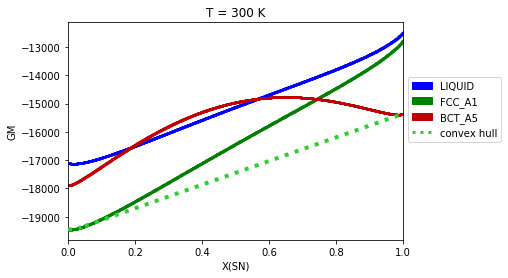

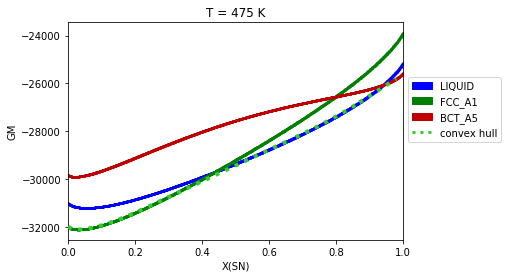

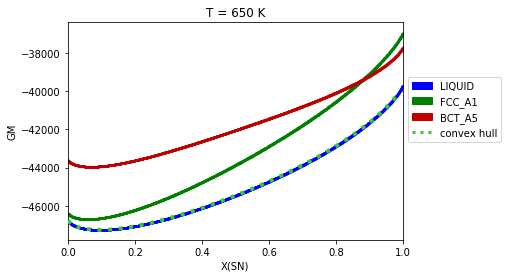

In [4]:
from pycalphad.plot.utils import phase_legend
import matplotlib.patches as mpatches

for T in [300, 475, 650]:
    legend_handles, color_dict = phase_legend(phases)
    plt.figure()
    # Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(SN)
    for phase_name in phases:
        result = calculate(dbf, comps, phase_name, P=101325, T=T, N=1, output='GM')
        plt.scatter(result.X.sel(component='SN'), result.GM, marker='.', s=5, color=color_dict[phase_name], label=phase_name)
    plot_convex_hull(dbf, comps, phases, {v.T: T, v.X('SN'): (0, 1, 0.01), v.N: 1, v.P: 1e5})
    legend_handles.append(mpatches.mlines.Line2D([], [], color='limegreen', label='convex hull', linestyle=':', lw=3))
    # Format the plot
    plt.title(f'T = {T} K')
    plt.xlabel('X(SN)')
    plt.ylabel('GM')
    plt.xlim((0, 1))
    plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
    plt.show()

In [5]:
%%time
binplot(dbf, comps, phases, {v.X('SN'): (0,1,0.02), v.T: (300, 600, 5), v.P:101325, v.N: 1}, plot_kwargs={'scatter': False})

KeyboardInterrupt: 

### Chemical potentials, T = 445 K

From the phase diagram, we expect that FCC_A1 will be stable until X(Sn) ~= 0.2, where FCC_A1 + BCT_A5 will be stable until nearly pure Sn.

To compute the chemical potentials, we need to determine the phases in equilibrium along the compositions in our chosen system. 

Calculations in pycalphad return `xarray` Dataset objects. Many details for using these objects from `calculate` and `equilibrium` are [documented at the pycalphad website](https://pycalphad.org/docs/latest/examples/UsingCalculationResults.html).

The object is printed out below. It contains 

* Dimensions and coordinates: these are the grid on which properties are calculated and tabulated
* Data variables: the quantities calculated at certain conditions on the grid of coordinates.

Chemical potentials are stored in the `MU` data variable, on a grid of `(N, P, T, X_SN, component)`. `N, P, T, X_SN` refer to the calculation conditions from an equilibrium calculation, while `component` refers to all of the pure elements in the calculation, i.e. Pb and Sn.


In [6]:
%%time
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325, v.N: 1, v.T: 445, v.X('SN'): (1e-3, 1, 0.005)})
print(eq_res)

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_SN: 200, component: 2, internal_dof: 3, vertex: 3)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 445.0
  * X_SN       (X_SN) float64 0.001 0.006 0.011 0.016 ... 0.986 0.991 0.996
  * vertex     (vertex) int32 0 1 2
  * component  (component) <U2 'PB' 'SN'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_SN, vertex) float64 1.0 nan nan 1.0 ... 1.0 nan nan
    GM         (N, P, T, X_SN) float64 -2.97e+04 -2.974e+04 ... -2.372e+04
    MU         (N, P, T, X_SN, component) float64 -2.969e+04 ... -2.367e+04
    X          (N, P, T, X_SN, vertex, component) float64 0.999 0.001 ... nan
    Y          (N, P, T, X_SN, vertex, internal_dof) float64 0.999 0.001 ... nan
    Phase      (N, P, T, X_SN, vertex) <U6 'FCC_A1' '' '' ... 'BCT_A5' '' ''
Attributes:
    engine:   pycalphad 0.8
    created:  2020-10-16T01:42:28.931773
Wall time: 11.5 s


Now plot the chemical potentals by accessing the `MU` data variables.

Note that `.squeeze()` eliminates the unnecessary dimensions of the data variables.


What observations can we make here?


1. $ G_M = \mu_\mathrm{Pb} x_{\mathrm{Pb}} + \mu_\mathrm{Sn} x_{\mathrm{Sn}} $ would exactly matches our convex hull. 
2. $ G_M = \mu_\mathrm{Sn} $ for pure Sn and $ G_M = \mu_\mathrm{Pb} $ for pure Pb. Everywhere else it's a mixture.
3. The chemical potential varys smoothly in single phase regions (Pb-rich FCC_A1), but is a straight line in two phase regions.

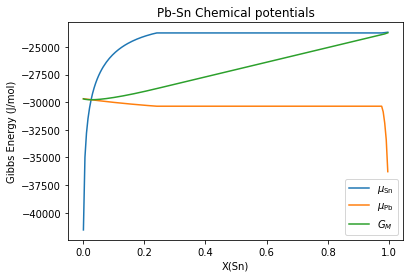

In [7]:
x_sn = eq_res.X_SN.squeeze()
x_pb = 1 - x_sn
mu_sn = eq_res.MU.sel(component='SN').squeeze()
mu_pb = eq_res.MU.sel(component='PB').squeeze()

# Plot chemical potentials
plt.plot(x_sn, mu_sn, label=r'$\mu_\mathrm{Sn}$')
plt.plot(x_sn, mu_pb, label=r'$\mu_\mathrm{Pb}$')

# Plot Gibbs energy
plt.plot(x_sn, x_sn*mu_sn+x_pb*mu_pb, label=r'$G_M$')
plt.title('Pb-Sn Chemical potentials')
plt.xlabel('X(Sn)')
plt.ylabel('Gibbs Energy (J/mol)')
plt.legend()

### Other interesting phase diagrams

#### Al-Zn (S. Mey, 1993)

The miscibility gap in the fcc phase is included in the Al-Zn diagram, shown below, with the critical point at ~ X(Zn)=0.35 and T=630 K.

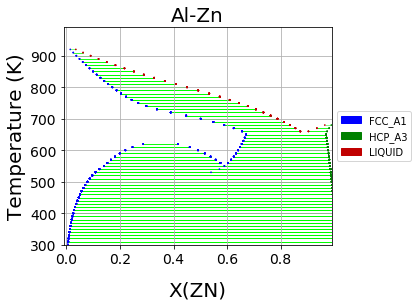

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, binplot
import pycalphad.variables as v

# Load database and choose the phases that will be considered
db_alzn = Database('alzn_mey.tdb')
my_phases_alzn = ['LIQUID', 'FCC_A1', 'HCP_A3']

# Compute the phase diagram and plot it on the existing axes using the `plot_kwargs={'ax': axes}` keyword argument
binplot(db_alzn, ['AL', 'ZN', 'VA'] , my_phases_alzn, {v.X('ZN'):(0,1,0.02), v.T: (300, 1000, 10), v.P:101325, v.N: 1})

#### Al-Mg (Y. Zhong, 2005)

Intermetallic phases and various invariant reactions occur.

Note that like other systems that we have plotted above, invariant reactions are not plotted as lines in pycalphad.

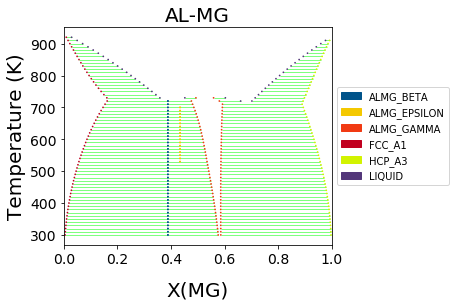

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, binplot
import pycalphad.variables as v

# Load database 
dbf = Database('Al-Mg_Zhong.tdb')
# Define the components
comps = ['AL', 'MG', 'VA']
# Get all possible phases programmatically
phases = dbf.phases.keys()

# Plot the phase diagram, if no axes are supplied, a new figure with axes will be created automatically
binplot(dbf, comps, phases, {v.N: 1, v.P:101325, v.T: (300, 1000, 10), v.X('MG'):(0, 1, 0.02)})

plt.show()

## Phases with internal degrees of freedom: Nb-Re (Liu, 2013)

As briefly mentioned in class, some phases can have internal degrees of freedom. You can plot energy surfaces for these systems in pycalphad.

In an equilibrium calculation, the software will optimize the phase internal degrees of freedom to give the lowest global minimum Gibbs energy.

Below is an example where the `CHI_RENB` phase has two sublattices where Nb and Re can enter each sublattice `(Nb,Re)(Nb,Re)` that give the phase two free internal variables.

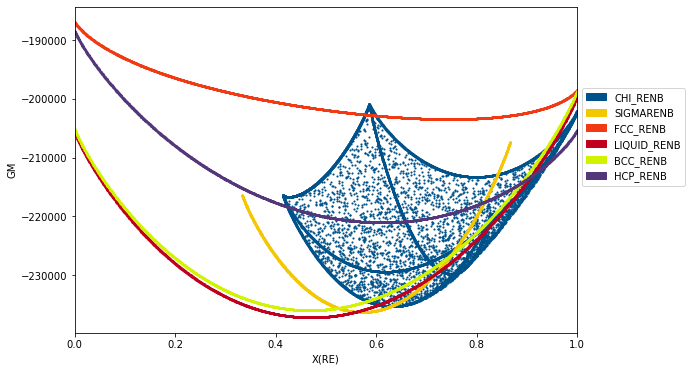

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, calculate, variables as v
from pycalphad.plot.utils import phase_legend
import numpy as np

# Load database and choose the phases that will be plotted
db_nbre = Database('nbre_liu.tdb')
my_phases_nbre = ['CHI_RENB', 'SIGMARENB', 'FCC_RENB', 'LIQUID_RENB', 'BCC_RENB', 'HCP_RENB']

# Get the colors that map phase names to colors in the legend
legend_handles, color_dict = phase_legend(my_phases_nbre)

fig = plt.figure(figsize=(9,6))
ax = fig.gca()

# Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(RE)
for phase_name in my_phases_nbre:
    result = calculate(db_nbre, ['NB', 'RE'], phase_name, P=101325, T=2800, output='GM')
    ax.scatter(result.X.sel(component='RE'), result.GM, marker='.', s=5, color=color_dict[phase_name])

# Format the plot
ax.set_xlabel('X(RE)')
ax.set_ylabel('GM')
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()